In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Analysis on Best Model
- Scaler: RobustScaler
- Feature Set: Feats#2
- Algorithm: XGBRegressor

## Helper Functions to Add Predicted Close Price to Test Data

In [2]:
# def train_test_split(df):
#     train_len = int(len(df)*.8)
#     train_dataset = df[:train_len]
#     test_dataset = df[train_len:len(df)]

#     train_features = train_dataset.copy()
#     test_features = test_dataset.copy()

#     train_labels = train_features.pop('Close')
#     test_labels = test_features.pop('Close')
#     return train_features, test_features, train_labels, test_labels

In [3]:
# def predict_fn(company, test_features, df, train_len=1967):
#     """
#     Helper function to predict test features
#     """
#     model = xgb.XGBRegressor()
#     model.load_model(f'./experiments_robust/XGBReg/models/{company}.json')
    
#     close_scaler = load(f'./experiments_robust/feature_engineering/{company}_close_scaler.bin')
    
#     features_scaler = load(f'./experiments_robust/feature_engineering/{company}_features_scaler.bin')
    
#     pred = model.predict(test_features)

#     actual_close = df[['Close']]
#     actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])

#     pred = pd.DataFrame(pred)
#     pred.reset_index(drop=True, inplace=True)
#     pred.index = test_features.index
#     pred['Actual'] = actual_close['Close']
#     pred.rename(columns={0:'Pred'}, inplace=True)
    
#     features = test_features.columns
#     test_features[features] = features_scaler.inverse_transform(test_features[features])
    
#     test_features['Predicted Close'] = pred['Pred']
#     test_features['Actual Close'] = pred['Actual']
    
#     test_features['Predicted Close'] = close_scaler.inverse_transform(
#         np.array(test_features['Predicted Close']).reshape(-1,1))
#     test_features['Actual Close'] = close_scaler.inverse_transform(
#         np.array(test_features['Actual Close']).reshape(-1,1))
    
#     return test_features

In [4]:
# for i in ['tlkm', 'isat', 'fren', 'excl']:
#     comp = i.upper()
#     df = pd.read_csv(f'./experiments_robust/cleaned_data/{comp}.csv', index_col='Date', parse_dates=True)
#     test_features = train_test_split(df)[1]
#     y_pred = predict_fn(i, test_features, df)
#     y_pred.to_csv(f'./experiments_robust/prediction_results/all_pred_{i}.csv')

## Helper Functions for Analysis

In [5]:
"""
TP, TN, FP, FN Definition:
1. TP: Actual Return = up and Predicted Return = up
2. TN: Actual Return = down and Predicted Return = down
3. FP: Actual Return = down and Predicted Return = up
4. FN: Actual Return = up and Predicted Return = down

To facilitate analysis
"""

def get_TPTNFPFN(df):
    dff = df.copy()[1:] # start from second row
    TP = dff[dff['TP']=='yes'].shape[0]
    TN = dff[dff['TN']=='yes'].shape[0]
    FP = dff[dff['FP']=='yes'].shape[0]
    FN = dff[dff['FN']=='yes'].shape[0]
    conf_mtx = [[TN, FP], [FN, TP]]
    
    sns.heatmap(conf_mtx/np.sum(conf_mtx), annot=True, fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show();
    
    acc = get_accuracy(TP, TN, FP, FN)
    
    return TP, TN, FP, FN, acc

def get_accuracy(tp, tn, fp, fn):
    acc = (tp+tn)/(tp+tn+fp+fn)
    return acc

def get_count_within_rmse_range(df):
    return df.groupby('Within RMSE Range').count()[['Predicted Close']]

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def get_rmse_mape_r2(df):
    rmse_ = rmse(df['Predicted Close'], df['Actual Close'])
    mape_ = mape(df['Actual Close'], df['Predicted Close'])
    r2_score_ = r2_score(df['Actual Close'], df['Predicted Close'])
    data = {'RMSE': [rmse_], 'MAPE': [mape_], 'R-squared': [r2_score_]}
    df = pd.DataFrame(data)
    return df

## ISAT.JK

In [7]:
isat = pd.read_csv('./error_analysis/isat_err_analysis.csv', 
                   index_col='Date', parse_dates=True, sep=';')
isat.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,...,Predicted Close,Actual Close,Diff,Within RMSE Range,Actual Return,Predicted Return,TP,TN,FP,FN
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,2295.71,2364.29,2391.43,45.77,14.72,27.49,34.75,41.59,34.87,46.39,...,2148.73,2080.0,-68.73,yes,down,down,no,yes,no,no
2020-09-11,2264.29,2335.00,2376.67,93.25,45.14,43.41,44.86,39.52,39.41,47.08,...,2316.82,2250.0,-66.82,yes,up,up,yes,no,no,no
2020-09-14,2252.86,2320.00,2370.00,88.64,46.45,44.18,45.38,36.15,41.45,48.46,...,2321.35,2260.0,-61.35,yes,up,up,yes,no,no,no
2020-09-15,2238.57,2305.00,2362.86,75.59,37.14,39.00,41.65,37.49,31.49,48.57,...,2144.45,2170.0,25.55,yes,down,down,no,yes,no,no
2020-09-16,2218.57,2281.43,2352.38,71.98,37.14,39.00,41.65,38.75,37.51,41.14,...,2121.08,2170.0,48.92,yes,up,down,no,no,no,yes


###  RMSE, MAPE, and R-squared

In [8]:
get_rmse_mape_r2(isat)

,RMSE,MAPE,R-squared
0,205.0523,2.218765,0.981415


In [9]:
get_count_within_rmse_range(isat)

,Predicted Close
Within RMSE Range,
no,76
yes,416


Terdapat 76 observasi memiliki error lebih kecil dari -RMSE dan lebih besar dari RMSE
> di luar range RMSE -205.05 < price < 25.05

#### The Predicted Price: Outside the RMSE Range

<AxesSubplot: xlabel='Date'>

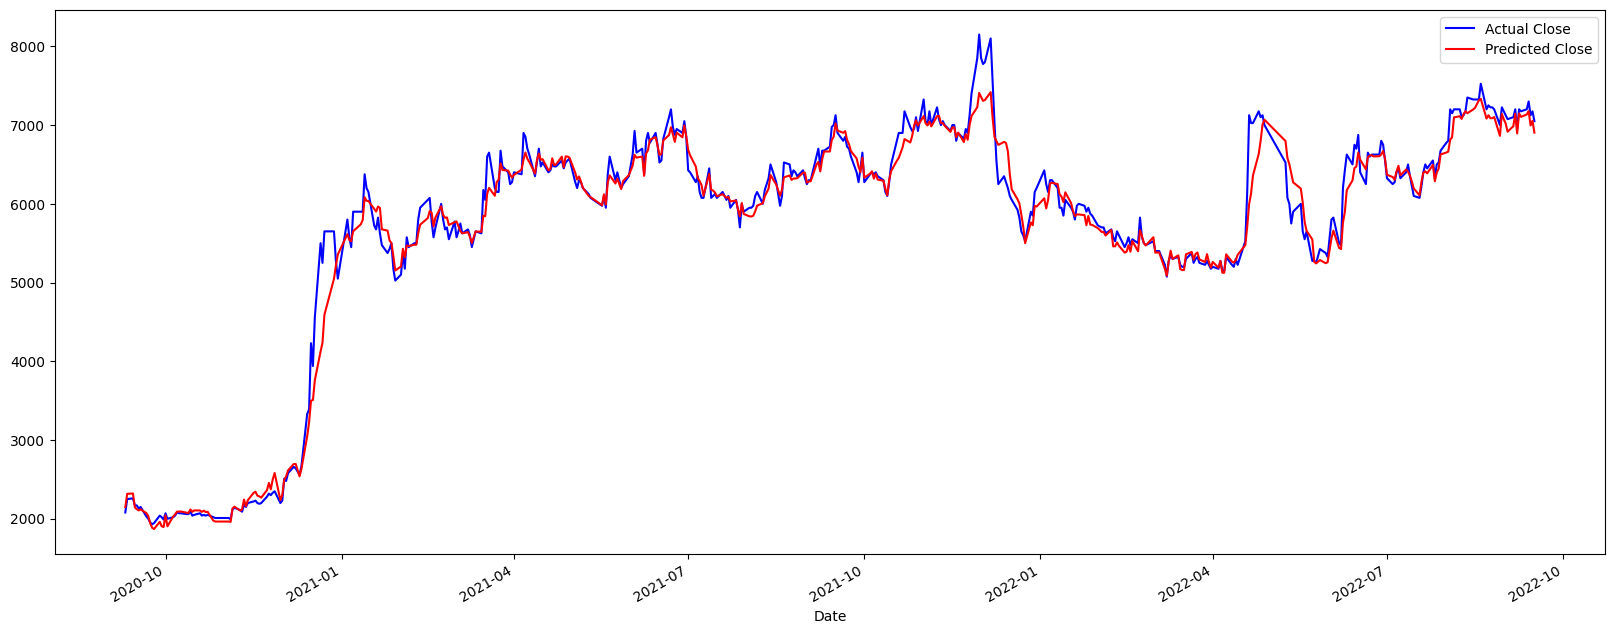

In [10]:
isat['Actual Close'].plot(figsize=(20,8), legend=True, color='blue')
isat['Predicted Close'].plot(legend=True, color='red', figsize=(20,8))

> Predicted Close < Actual Close

In [11]:
a = isat[(isat['Within RMSE Range']=='no') & (isat['Diff']>=0)]
a.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

,,Predicted Close,Actual Close
year,month,,
2020,12,8,8
2022,6,7,7
2021,12,6,6
2022,4,6,6
2021,3,4,4


Pada bulan Desember 2020, terdapat 8 observasi dengan harga prediksi Close di bawah harga aktual Close, diikuti oleh bulan Juni 2022, Desember 2021, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Desember 2020 dan Desember 2021, terdapat perbedaan yang signifikan antara Predicted Close dan Actual Close dimana Predicted Close berada di bawah Actual Close.

> Predicted Close > Actual Close

In [12]:
b = isat[(isat['Within RMSE Range']=='no') & (isat['Diff']<0)]
b.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2022 5                    8             8
2021 12                   7             7
     1                    4             4
     7                    2             2
2020 11                   1             1

Pada bulan Mei 2022, terdapat 8 observasi dengan harga prediksi Close di atas harga aktual Close, diikuti oleh bulan Desember 2021, Januari 2021, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan Mei 2022, terdapat perbedaan yang cukup terlihat antara Predicted Close dan Actual Close dimana Predicted Close berada di atas Actual Close.

#### The Predicted Price: 5 or More Observations that are Outside the RMSE Range
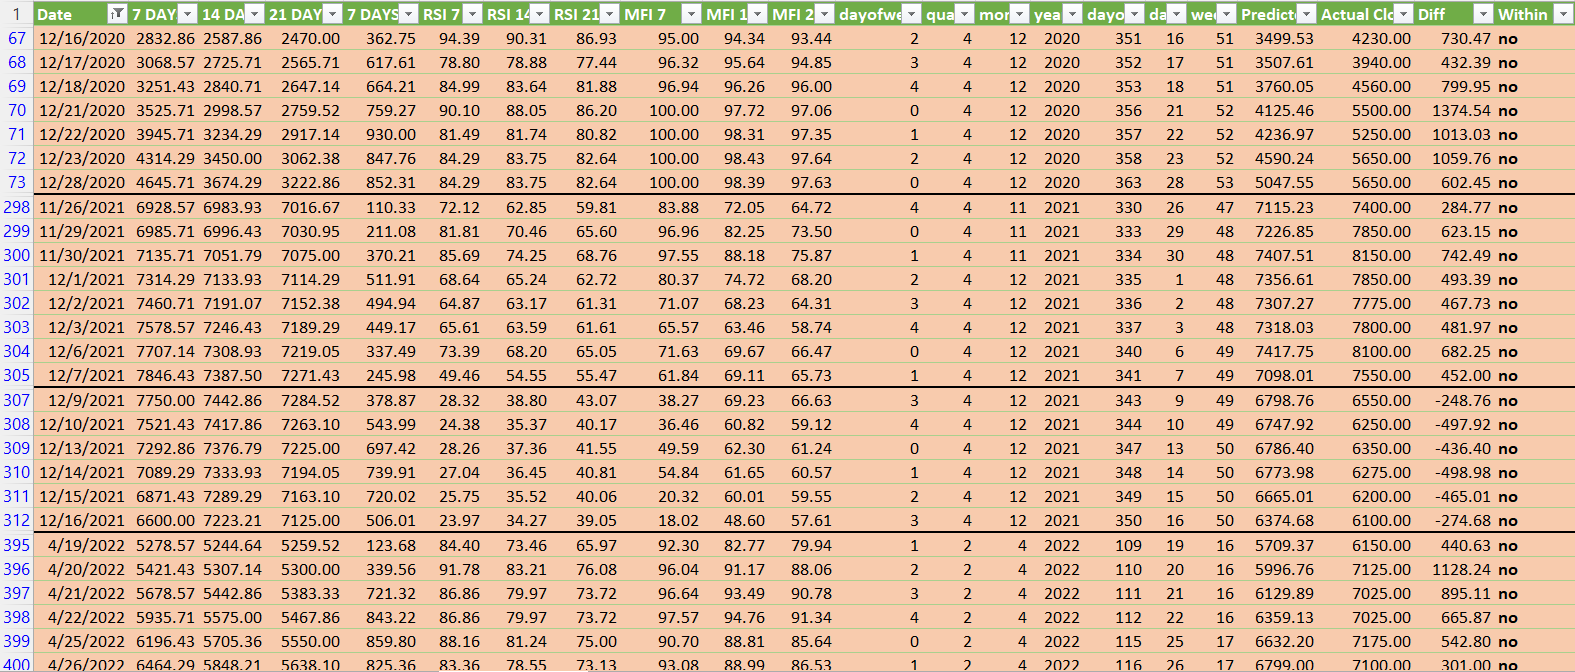

Dari tabel di atas, ketika model memprediksi harga yang di luar dari RMSE range di waktu tertentu, dalam beberapa kasus akan secara beruntun memprediksi harga di luar dari RMSE range sampai periode waktu tertentu. Selain itu, dalam periode waktu tersebut, harga prediksi akan selalu lebih kecil dari harga aktual (nilai Diff positif) atau sebaliknya (nilai Diff negatif). 

#### Error Terbesar

*Harga aktual lebih besar dari harga yang diprediksi*

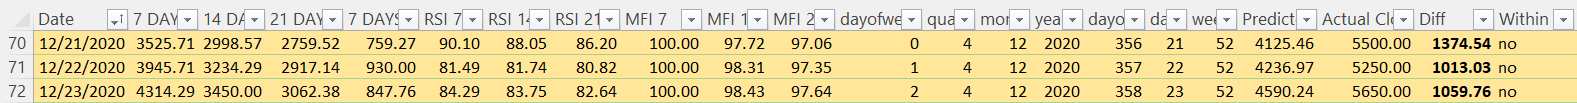

*Harga aktual lebih kecil dari harga yang diprediksi*

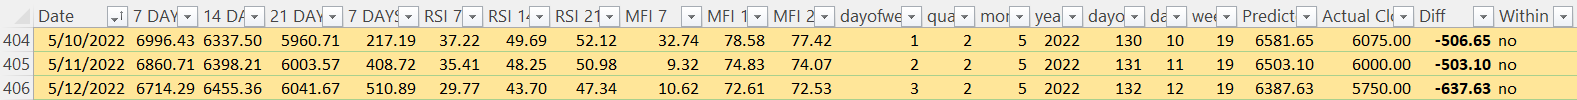

Dari tabel di atas, bisa dilihat bahwa model tidak berhasil memprediksi harga pada tanggal 21, 22, dan 23 Desember 2020 dengan baik (error 1000++), dimana harga aktual mengalami peningkatan yang signifikan. Begitu juga pada tanggal 10, 11, dan 12 Mei 2022, model tidak berhasil memprediksi harga di tanggal tersebut dengan baik (error -500++), dimana harga aktual mengalami penurunan yang cukup signifikan.

### Sudut Pandang Klasifikasi: Naik atau Turun (dari Harga Sebelumnya)
- Naik (Up) => Positive
- Turun (Down) => Negative

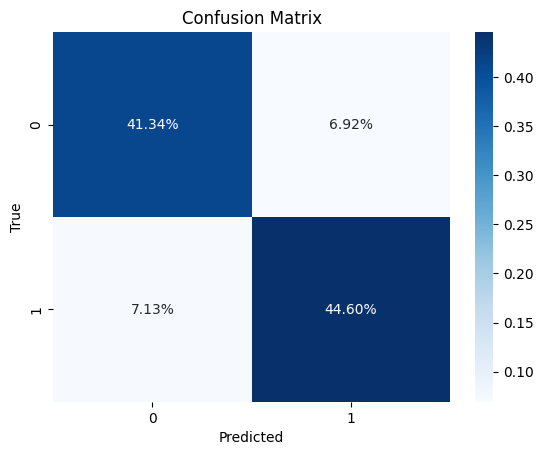

In [13]:
isat_tp, isat_tn, isat_fp, isat_fn, isat_acc = get_TPTNFPFN(isat)

In [14]:
isat_acc

0.8594704684317719

Model sudah dengan cukup baik memprediksi pergerakan harga saham (naik atau turun) dengan akurasi 86%.

## EXCL.JK

In [15]:
excl = pd.read_csv('./error_analysis/excl_err_analysis.csv', 
                   index_col='Date', parse_dates=True, sep=';')
excl.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,...,Predicted Close,Actual Close,Diff,Within RMSE Range,Actual Return,Predicted Return,TP,TN,FP,FN
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-10,2307.14,2407.86,2434.29,87.51,8.72,21.45,28.99,0.00,19.62,41.73,...,2052.86,2040.0,-12.86,yes,down,down,no,yes,no,no
2020-09-11,2252.86,2373.57,2415.24,118.28,36.95,35.71,37.83,19.57,29.35,46.24,...,2195.32,2190.0,-5.32,yes,up,up,yes,no,no,no
2020-09-14,2221.43,2352.14,2402.86,96.86,47.12,41.78,41.88,34.23,35.03,50.15,...,2231.88,2270.0,38.12,yes,up,up,yes,no,no,no
2020-09-15,2211.43,2337.14,2396.19,85.52,40.46,38.36,39.52,35.56,30.27,47.62,...,2201.56,2200.0,-1.56,yes,down,down,no,yes,no,no
2020-09-16,2197.14,2312.86,2385.24,76.10,34.73,35.26,37.30,38.83,24.11,39.41,...,2161.48,2130.0,-31.48,yes,down,down,no,yes,no,no


###  RMSE, MAPE, and R-squared

In [16]:
get_rmse_mape_r2(excl)

,RMSE,MAPE,R-squared
0,47.70265,1.370275,0.981126


In [17]:
get_count_within_rmse_range(excl)

,Predicted Close
Within RMSE Range,
no,127
yes,365


Terdapat 127 observasi memiliki error lebih kecil dari -RMSE dan lebih besar dari RMSE
> di luar range RMSE -47.70 < price < 47.70

#### The Predicted Price: Outside the RMSE Range

<AxesSubplot: xlabel='Date'>

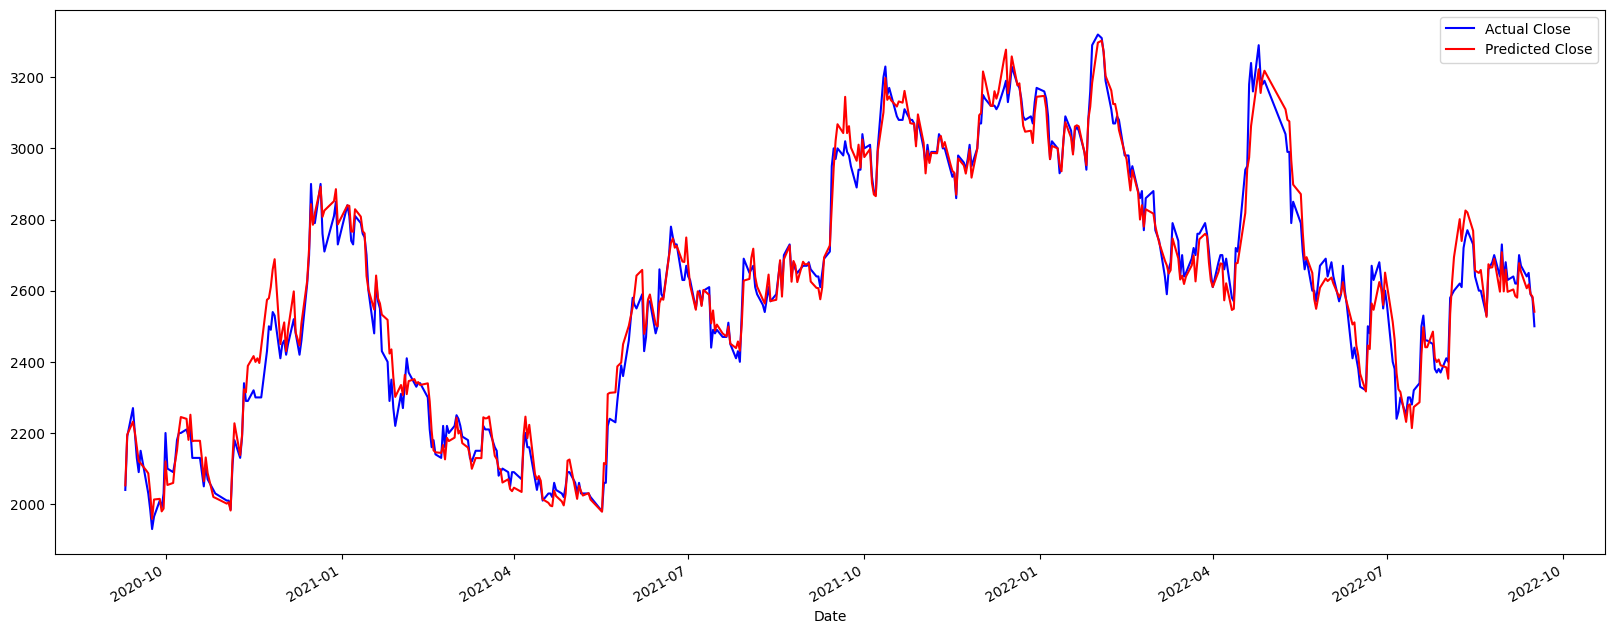

In [18]:
excl['Actual Close'].plot(figsize=(20,8), legend=True, color='blue')
excl['Predicted Close'].plot(legend=True, color='red', figsize=(20,8))

> Predicted Close < Actual Close

In [19]:
c = excl[(excl['Within RMSE Range']=='no') & (excl['Diff']>=0)]
c.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2022 4                    7             7
     3                    5             5
     6                    4             4
     7                    3             3
     1                    2             2

Pada bulan April 2022, terdapat 7 observasi dengan harga prediksi Close di bawah harga aktual Close, diikuti oleh bulan Maret 2022, Juni 2022, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan April 2022 dan Maret 2022, terdapat perbedaan yang cukup terlihat antara Predicted Close dan Actual Close dimana Predicted Close berada di bawah Actual Close.

> Predicted Close > Actual Close

In [20]:
d = excl[(excl['Within RMSE Range']=='no') & (excl['Diff']<0)]
d.groupby(['year','month']).count()[['Predicted Close', 'Actual Close']].sort_values('Predicted Close', ascending=False).head()

Predicted Close  Actual Close
year month                               
2020 11                  11            11
2021 9                    9             9
2022 8                    8             8
     5                    8             8
2021 1                    7             7

Pada bulan November 2020, terdapat 11 observasi dengan harga prediksi Close di atas harga aktual Close, diikuti oleh bulan September 2021, Agustus 2022, dan seterusnya. Bisa dilihat juga dari *line plot* di atas bahwa pada bulan November 2020, September 2021, Agustus 2022, terdapat perbedaan yang signifikan antara Predicted Close dan Actual Close dimana Predicted Close berada di atas Actual Close.

#### The Predicted Price: 5 or More Observations that are Outside the RMSE Range
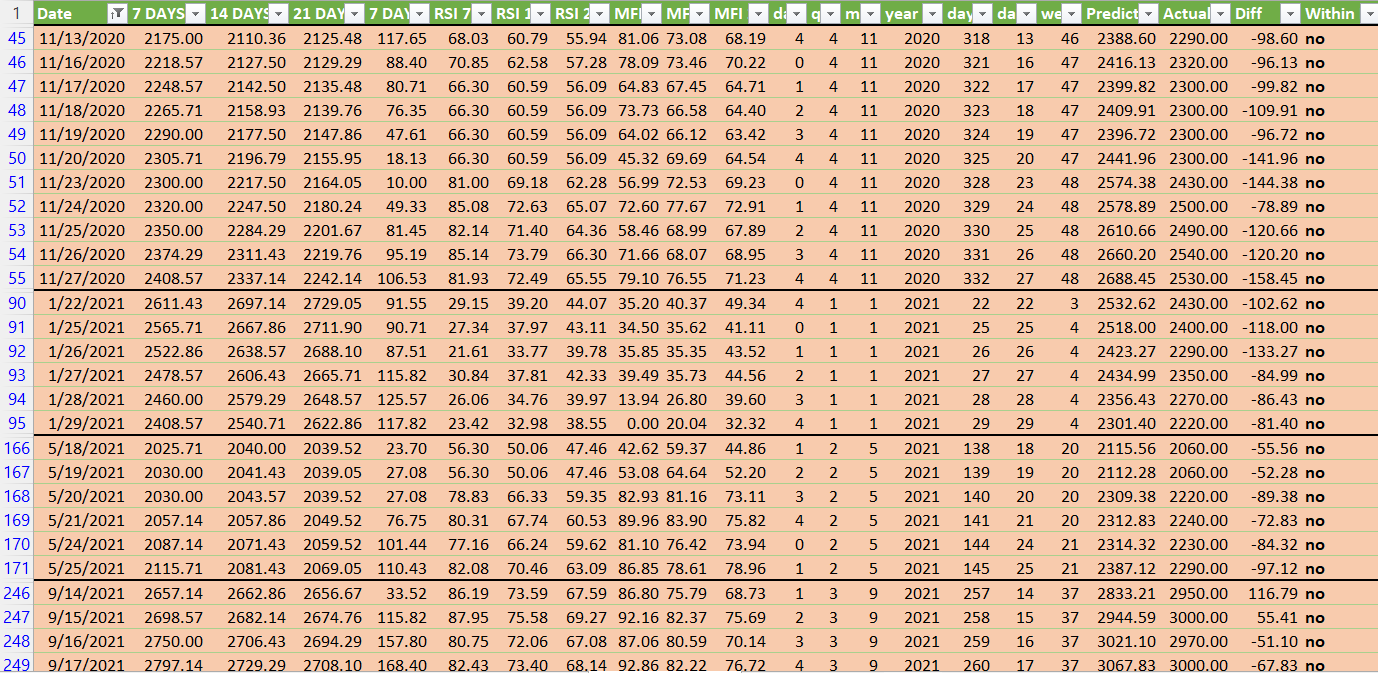

Dari tabel di atas, ketika model memprediksi harga yang di luar dari RMSE range di waktu tertentu, dalam beberapa kasus akan secara beruntun memprediksi harga di luar dari RMSE range sampai periode waktu tertentu. Selain itu, dalam periode waktu tersebut, harga prediksi akan selalu lebih kecil dari harga aktual (nilai Diff positif) atau sebaliknya (nilai Diff negatif). 

### Sudut Pandang Klasifikasi: Naik atau Turun (dari Harga Sebelumnya)
- Naik (Up) => Positive
- Turun (Down) => Negative

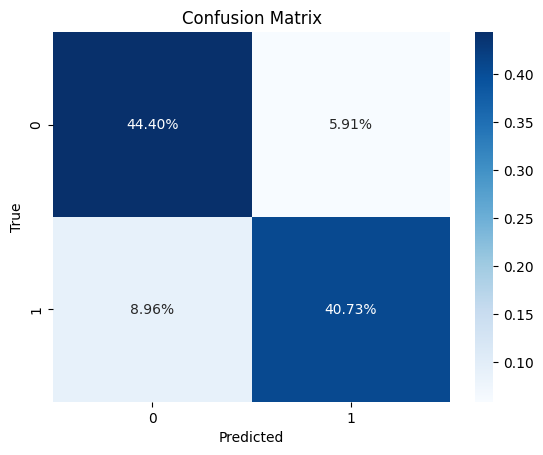

Accuracy: 0.8513238289205702


In [22]:
excl_tp, excl_tn, excl_fp, excl_fn, excl_acc = get_TPTNFPFN(excl)
print(f'Accuracy: {excl_acc}')

Model sudah dengan cukup baik memprediksi pergerakan harga saham (naik atau turun) dengan akurasi 85%.

# Kesimpulan
Harga saham sangat ditentukan oleh kekuatan permintaan (demand) dan penawaran (supply). Permintaan adalah jumlah saham yang ingin dibeli orang, sedangkan, penawaran adalah jumlah saham yang ingin dijual orang. Penentuan harga terjadi ketika permintaan dan penawaran bertemu pada tingkat harga tertentu (ekuilibrium), yaitu pembeli dan penjual sepakat untuk melakukan transaksi pada titik harga tertentu. 

Kekuatan permintaan (demand) dan penawaran (supply) diperngaruhi oleh performa bisnis perusahaan. Permintaan akan kian meningkat jika bisnis berjalan dengan baik karena semakin banyak investor yang ingin membeli saham dari perusahaan tersebut untuk mendapatkan keuntungan finansial, berlaku sebaliknya. Jika penawaran meningkat (permintaan tidak meningkat), hal ini bisa merujuk kepada penjual cenderung menawar harga dengan harapan dapat menarik pembeli untuk membeli saham. Saat permintaan dan penawaran bertemu di titik harga tertentu, besar kemungkinan harga yang disepakati itu rendah, sehingga harga saham menurun (Motilal Oswal Financial Services Limited. 2022).

Pada eksperimen dan penelitian yang kami lakukan, digunakan data historis harga saham sebagai prediktor yang terdiri atas High, Low, Close, dan Volume dimana variabel ini diekstraksi lebih lanjut dengan formula technical analysis MA, RSI, MFI, STD DEV. Variabel lain yang digunakan adalah variabel yang diekstraksi dari tanggal (minggu, tahun, kuartal, dst). Pada model ini, dipelajari pola harga Close berdasarkan variabel independen tersebut. Namun, pada beberapa kasus, model tidak berhasil memprediksi harga saham dengan cukup baik karena harga aktual yang terlalu tinggi atau rendah pada suatu waktu, dimana hal ini dipengaruhi oleh kekuatan permintaan dan penawaran yang juga dipengaruhi oleh performa bisnis perusahaan. 

Untuk memfasilitasi model agar mempelajari dampak performa bisnis perusahaan - kekuatan permintaan dan penawaran, data terkait bisa ditambahkan sebagai variabel independen (prediktor). Misalkan, analisis sentimen investor dan publik terhadap suatu perusahaan, kondisi keuangan perusahaan, berita terkait perusahaan, dan lain lain.

# Daftar Pustaka
Motilal Oswal Financial Services Limited. 2022, *How are stock prices determined?*, viewed 3 December 2022, <https://www.motilaloswal.com/blog-details/how-are-stock-prices-determined-/34>.